# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы 
его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensor

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
train_transform = A.Compose([
    #A.VerticalFlip(p=0.5),
    #A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensor(),
])
for_training = lambda image: val_transform(image=np.array(image)) 

In [5]:
val_transform = A.Compose([
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensor()
])
for_validation = lambda image: train_transform(image=np.array(image)) 

In [7]:
! unzip -qq /content/drive/MyDrive/dataset.zip

In [8]:
train_dataset = torchvision.datasets.ImageFolder("./dataset/train",
                                                     transform=for_training
                                                     )

val_dataset = torchvision.datasets.ImageFolder("./dataset/val",
                                                   transform=for_validation
                                                   )

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=2)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                         shuffle=False, num_workers=2)

optional, do not run 

In [10]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [12]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)
resnet50.to(device)
None

In [10]:
import torchvision.models as models
resnext101 = models.resnext101_32x8d(pretrained=True)
resnext101.to(device)
None

In [13]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler=None, device="cuda:0"):
    model.train()
    train_loss = 0

    predicted_labels = np.array([])
    true_labels = np.array([])

    for X_batch, y_batch in tqdm(train_dataloader):

        X_batch = X_batch['image'].to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        #scheduler.step()


        predicted_labels = np.append(predicted_labels, y_pred.argmax(1).cpu().detach().numpy())
        true_labels = np.append(true_labels, y_batch.cpu().detach().numpy())
    
    accuracy = accuracy_score(predicted_labels, true_labels)
    return train_loss, accuracy


def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.eval()
    val_loss = 0
    val_acc = 0
    predicted_labels = np.array([])
    true_labels = np.array([])


    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_dataloader):

                X_batch = X_batch['image'].to(device)
                y_batch = y_batch.to(device)

                pred = model(X_batch)
                loss = criterion(pred, y_batch)
                val_loss += loss.item()

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == y_batch).sum().item()
                predicted_labels = np.append(predicted_labels, pred.argmax(1).cpu().detach().numpy())
                true_labels = np.append(true_labels, y_batch.cpu().detach().numpy())

    return val_loss, predicted_labels, true_labels 


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device="cuda:0", n_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(n_epochs):
        print(f'\n epoch number {epoch + 1}')
        # one epoch train loop
        t_loss, t_acc = train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler, device="cuda:0")
        train_losses.append(t_loss)
        train_accuracy.append(t_acc)

        # one epoch validation loop
        v_loss, pred, true = predict(model, val_dataloader, criterion, device="cuda:0")
        val_losses.append(v_loss)
        v_acc = accuracy_score(pred, true)
        val_accuracy.append(v_acc)

        scheduler.step()
 
       
        print(f'\n epoch train loss: {t_loss}')
        print(f' epoch train accuracy: {t_acc}')
        print(f' epoch val loss: {v_loss}')
        print(f' epoch val accuracy: {v_acc}')

    return train_losses, train_accuracy, val_losses, val_accuracy

In [17]:
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

n_epochs = 40

Простой тест на проверку правильности написанного кода

In [16]:
all_losses, predicted_labels, true_labels = predict(resnet50, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

100%|██████████| 157/157 [00:06<00:00, 26.12it/s]


tests passed


In [14]:
from tqdm import tqdm

Запустить обучение можно в ячейке ниже.

In [18]:
train_losses, train_accuracy, val_losses, val_accuracy = train(resnet50 , train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs=20)

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch number 1


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 4708.901418566704
 epoch train accuracy: 0.3309
 epoch val loss: 369.2150720357895
 epoch val accuracy: 0.447

 epoch number 2


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 2936.875543475151
 epoch train accuracy: 0.53034
 epoch val loss: 320.8170138001442
 epoch val accuracy: 0.5047

 epoch number 3


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 2248.7295584082603
 epoch train accuracy: 0.62493
 epoch val loss: 308.758072078228
 epoch val accuracy: 0.5247

 epoch number 4


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 1682.272145241499
 epoch train accuracy: 0.70925
 epoch val loss: 326.8794842362404
 epoch val accuracy: 0.5186

 epoch number 5


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 1223.6831847727299
 epoch train accuracy: 0.78003
 epoch val loss: 332.2711852192879
 epoch val accuracy: 0.527

 epoch number 6


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 387.3187955506146
 epoch train accuracy: 0.93082
 epoch val loss: 335.25030636787415
 epoch val accuracy: 0.5675

 epoch number 7


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 134.67258558236063
 epoch train accuracy: 0.97851
 epoch val loss: 377.37862771749496
 epoch val accuracy: 0.5619

 epoch number 8


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 57.19723035348579
 epoch train accuracy: 0.99131
 epoch val loss: 451.0982008576393
 epoch val accuracy: 0.559

 epoch number 9


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 36.91054289811291
 epoch train accuracy: 0.9942
 epoch val loss: 483.00566869974136
 epoch val accuracy: 0.5559

 epoch number 10


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 28.370682748849504
 epoch train accuracy: 0.9956
 epoch val loss: 500.8272711634636
 epoch val accuracy: 0.556

 epoch number 11


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 20.00874055630993
 epoch train accuracy: 0.9973
 epoch val loss: 492.97920167446136
 epoch val accuracy: 0.5584

 epoch number 12


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 14.322758941387292
 epoch train accuracy: 0.99832
 epoch val loss: 494.31308114528656
 epoch val accuracy: 0.5622

 epoch number 13


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 11.93070609375718
 epoch train accuracy: 0.9986
 epoch val loss: 494.3126748204231
 epoch val accuracy: 0.5632

 epoch number 14


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 10.172745804156875
 epoch train accuracy: 0.99875
 epoch val loss: 499.61368304491043
 epoch val accuracy: 0.5621

 epoch number 15


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 9.313618723652326
 epoch train accuracy: 0.9988
 epoch val loss: 504.3045821785927
 epoch val accuracy: 0.5625

 epoch number 16


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 7.91341004151036
 epoch train accuracy: 0.99906
 epoch val loss: 504.0962253212929
 epoch val accuracy: 0.5596

 epoch number 17


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 8.617664913530461
 epoch train accuracy: 0.99895
 epoch val loss: 503.6128258705139
 epoch val accuracy: 0.561

 epoch number 18


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 7.841753859742312
 epoch train accuracy: 0.99921
 epoch val loss: 502.5693006515503
 epoch val accuracy: 0.564

 epoch number 19


  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch train loss: 7.682379116595257
 epoch train accuracy: 0.99915
 epoch val loss: 504.31407964229584
 epoch val accuracy: 0.5649

 epoch number 20


100%|██████████| 157/157 [00:05<00:00, 29.04it/s]


 epoch train loss: 8.623818331077928
 epoch train accuracy: 0.99896
 epoch val loss: 503.93788009881973
 epoch val accuracy: 0.5653


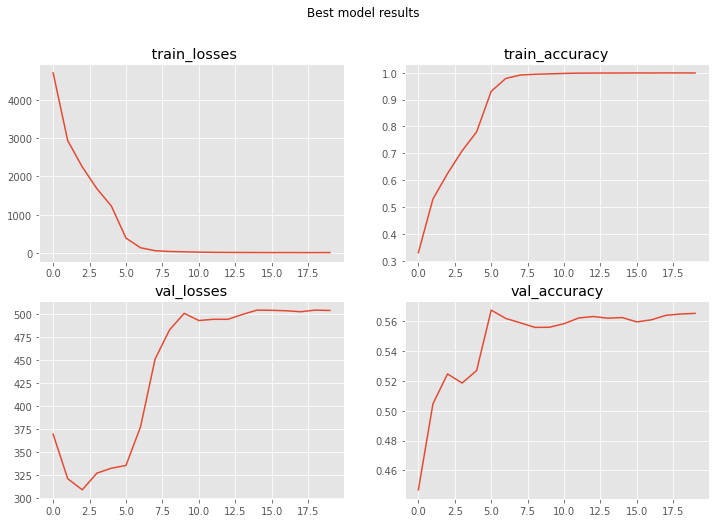

In [19]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 2, sharex=False, figsize=(12, 8))
fig.suptitle('Best model results')
axes[0, 0].plot(train_losses, label='train_losses')
axes[0, 0].set_title(' train_losses')

axes[0, 1].plot(train_accuracy, label='train_accuracy')
axes[0, 1].set_title('train_accuracy')

axes[1, 0].plot(val_losses, label='val_losses')
axes[1, 0].set_title('val_losses')

axes[1, 1].plot(val_accuracy, label='val_accuracy')
axes[1, 1].set_title('val_accuracy')
plt.show()

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [21]:
all_losses, predicted_labels, true_labels = predict(resnet50, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5 * accuracy / 0.44)))
print(f'accuracy score is {accuracy}')

100%|██████████| 157/157 [00:05<00:00, 28.37it/s]

Оценка за это задание составит 5 баллов
accuracy score is 0.5652


__Ваш отчёт о проделанных экспериментах__: текст писать тут

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [22]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
! pip install xmltodict

Датасет мы за вас написали.

In [31]:
pip install -U albumentations

     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 952kB 12.2MB/s 
     |████████████████████████████████| 36.7MB 88kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import xmltodict
import json
import glob
import time
import cv2
import os

import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc


import albumentations as A
from albumentations.pytorch import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [3]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [6]:
train_transform = A.Compose([
    #A.RandomCrop(width=224, height=224, p=1),
    #A.HorizontalFlip(p=0.1),
    #A.RandomBrightnessContrast(p=0.1),
    ToTensor(), 
], bbox_params=A.BboxParams(format='pascal_voc', min_area=1024, min_visibility=0.1, label_fields=['labels']))

In [7]:
val_transform = A.Compose([
    #A.RandomCrop(width=224, height=224),
    ToTensor(), 
], bbox_params=A.BboxParams(format='pascal_voc', min_area=1024, min_visibility=0.1, label_fields=['labels']))

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = FruitDataset("/content/drive/My Drive/train_zip/train", transform=train_transform)
val_dataset = FruitDataset("/content/drive/My Drive/test_zip/test", transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn)

Some useful train functions 

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """


    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]


            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))


    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))
    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        print("epoch {}/{}..".format(epoch + 1, n_epochs))
        start = time.time()
        train_one_epoch(model, train_dataloader, optimizer, device)
        mAP = evaluate(model, val_dataloader, device=device)
        end = time.time()

        print("epoch {} done in {}s".format(epoch + 1, round(end - start, 2)))
        print("mAP after epoch {} is {}:".format(epoch + 1, round(mAP, 3)))

In [ ]:
def get_detection_model(num_classes=4):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

  
model = get_detection_model(num_classes=4)
model.to(device)
None

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

n_epochs = 5

train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

epoch 1/5..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss value after 10 batches is 0.63
Loss value after 20 batches is 0.54
Loss value after 30 batches is 0.49
Loss value after 40 batches is 0.46
Loss value after 50 batches is 0.42
Loss value after 60 batches is 0.39
Loss value after 70 batches is 0.36
Loss value after 80 batches is 0.35
Loss value after 90 batches is 0.33
Loss value after 100 batches is 0.33
Loss value after 110 batches is 0.33
Loss value after 120 batches is 0.32
epoch 0 done in 102.32s
mAP after epoch 0 is 0.863:
epoch 2/5..
Loss value after 10 batches is 0.29
Loss value after 20 batches is 0.25
Loss value after 30 batches is 0.26
Loss value after 40 batches is 0.25
Loss value after 50 batches is 0.25
Loss value after 60 batches is 0.24
Loss value after 70 batches is 0.23
Loss value after 80 batches is 0.22
Loss value after 90 batches is 0.22
Loss value after 100 batches is 0.21
Loss value after 110 batches is 0.21
Loss value after 120 batches is 0.21
epoch 1 done in 102.46s
mAP after epoch 1 is 0.947:
epoch 3/5..
Lo

__Выведите итоговое качество модели__.

In [ ]:
metric = evaluate(model, val_dataloader, device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * metric / 0.91)))
metric

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Оценка за это задание составит 4 баллов


0.9850595449290869

Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [ ]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


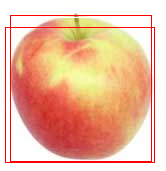

In [ ]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], utline='green')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

In [ ]:
# YOUR CODE

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.

Фидбэк
1. Местами втречаюся явные ошибки в коде: неправильно написанные функции, ошибочные указания. Это в достаточной степени осложняет работу, так как приходится фокусироваться не на задании, а на испралении существующих данных формул

In [2]:
import numpy as np 

In [4]:
list(map(int, np.random.uniform(0,1000, 20)))

[206,
 205,
 792,
 622,
 419,
 919,
 679,
 742,
 971,
 760,
 588,
 73,
 223,
 888,
 210,
 995,
 191,
 884,
 17,
 285]

In [ ]:
xx = np.array([[0.36, -0.03], [-0.03, 0.09]])
s_2 = 25

In [ ]:
2 + 2 * np.sqrt()